# Fundamentals of Machine Learning - Exercise 5
Deadline: 2021.01.26, 16:00

Zhao SUN, Johannes Kammerer, Tong Yu

In [1]:
import numpy as np       
import matplotlib.pyplot as plt         
%matplotlib inline
from IPython.display import display, Markdown, Latex

from scipy.sparse import coo_matrix, csc_matrix, linalg


### Constructing the matrix X (25 points)

In [2]:
def construct_X(M:int, alphas:list, Np=None):
    """ M: size of 2D tomogram (M x M)
        alphas: list of orientations in degree
        Np: size of sensory array
        Return: sparse matrix
    """
    # set up sensor array if not provided
    if Np == None:
        Np = int(np.ceil(np.sqrt(2)*M)//2*2+1)  #round up to the next odd int
        
    # specify the expected shape of output matrix
    N = int(Np*len(alphas))
    D = int(M*M)
    
    # set up containers for sparse matrix parameters
    weights = np.empty((0,))
    i_indices = np.empty((0,),int)
    j_indices = np.empty((0,),int)
    
    # create an array C to hold the coordinates of the tomogram's pixel centers
    C = np.zeros((2,D))    
    
    # set the origin of the new coordinates at the center of img
    # transform the origin of the first pixel in the original img into new coordinates
    a0 = -(M/2 - 0.5)
    b0 = -(M/2 - 0.5)
        
    # vectorized implemenation of centers of all pixels
    x = np.mgrid[0:M,0:M]
    ja = x[1].reshape(-1)
    jb = x[0].reshape(-1)
    
    j = ja + jb*M    # effectively same as np.arange(D)
    
    # re-express the centers of all img pixels in new coordinates
    C[0,:] = a0 + ja
    C[1,:] = b0 + jb
  
    # distance from first sensor element center to the origin in the new coordinates system
    s0 = (Np-1)/2
    
    # unit vector along the rotated sensor projection of each pixel onto the sensor: p = np.dot(n.T,C)
    for k in range(len(alphas)):
        a = np.radians(alphas[k])   # convert degree to radian
        
        n = np.array([np.cos(a),-np.sin(a)])   # rotation matrix for projection onto new axis
        p = np.dot(n.T,C) + s0
                
        w0 = np.ceil(p) - p         # vector size D, weight allocated to proceeding integer
        i0 = np.floor(p) + k*Np     # vector size D, i = ip + Np*io
        j0 = j                      # vector size D, j = ja + M*jb
        
        w1 = p - np.floor(p)
        i1 = i0+1
        j1 = j
        
        weights = np.concatenate([weights,w0,w1])
        i_indices = np.concatenate([i_indices,i0,i1])
        j_indices = np.concatenate([j_indices,j0,j1])
    
    #print(s0, Np,N, '>>', i_indices.min(),i_indices.max())
    #print(i_indices[:15])
    
    X = coo_matrix((weights, (i_indices.astype(int), j_indices.astype(int))), shape=(N, D), dtype = np.float32)   
    
    return X



X_construct is identical to X_example: True


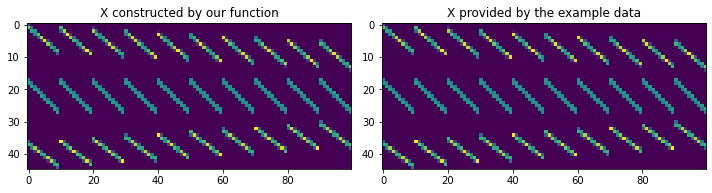

In [3]:
X_construct = construct_X(10,[-33,1,42]).toarray()
X_ex = np.load('hs_tomography/X_example.npy')

fig, ax = plt.subplots(1,2, figsize=(10,4),tight_layout=True)
ax[0].imshow(X_construct)
ax[0].set_title("X constructed by our function")

ax[1].imshow(X_ex)
ax[1].set_title("X provided by the example data");

print(f'X_construct is identical to X_example: {np.all(X_construct == X_ex)}')


### Recovering the image (6 points)

In [ ]:
alphas_77 = np.load('hs_tomography/alphas_77.npy')
X_ref = np.load('hs_tomography/X_77.npy',allow_pickle=True)[()].toarray() 
X_ref.shape == X_77.shape, X_ref.max(),X_77.max(), X_ref.min()==X_77.min()
csc_matrix(X_ref).count_nonzero(),csc_matrix(X_77).count_nonzero()


Num of nonzero elements in X_ref = 1066978 
Num of nonzero elements in X_77 = 1066736
COMMENTS: Not sure where the above discrepencies are from and why the images are all black?


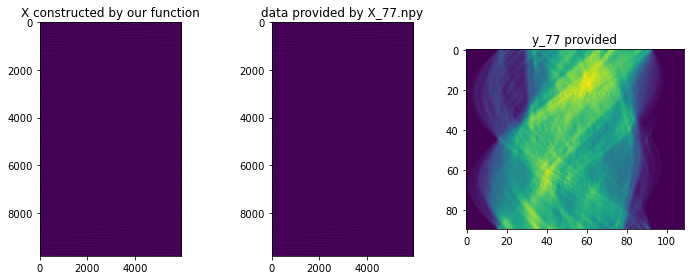

In [6]:
alphas_77 = np.load('hs_tomography/alphas_77.npy')
# len(alphas_77) == 90

y_77 = np.load('hs_tomography/y_77.npy')
X_ref = np.load('hs_tomography/X_77.npy',allow_pickle=True)[()] #Compressed Sparse Column format - # [()] trick to get to the underlying data

X_77 = construct_X(M=77,alphas=alphas_77,Np=109)

fig, ax = plt.subplots(1,3, figsize=(10,4),tight_layout=True)
ax[0].imshow(X_77.toarray())
ax[0].set_title("X constructed by our function")

ax[1].imshow(X_ref.toarray())
ax[1].set_title("data provided by X_77.npy");

ax[2].imshow(y_77.reshape(-1,109))
ax[2].set_title("y_77 provided");

print(f'Num of nonzero elements in X_ref = {csc_matrix(X_ref).count_nonzero()} \nNum of nonzero elements in X_77 = {csc_matrix(X_77).count_nonzero()}')
#print(f'X_construct is identical to X_ref: {np.allclose(X_77, X_ref,rtol=1e-05, atol=1e-5)}')
print('COMMENTS: Not sure where the above discrepencies are from and why the images are all black?')


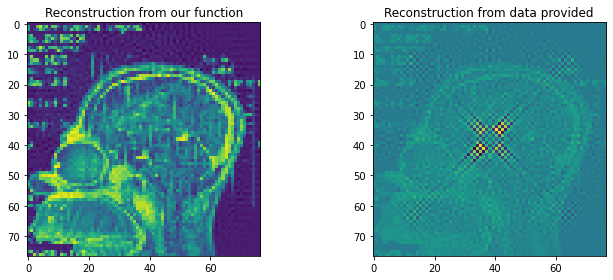

In [7]:
beta_ref = linalg.lsqr(A = X_ref, b =y_77, atol = 1e-05, btol = 1e-05)[0]
beta_77 = linalg.lsqr(A = X_77, b =y_77, atol = 1e-05, btol = 1e-05)[0]
M = 77

fig, ax = plt.subplots(1,2, figsize=(10,4),tight_layout=True)
ax[0].imshow(beta_ref.reshape(M,M))
ax[0].set_title("Reconstruction from our function")

ax[1].imshow(beta_77.reshape(M,M))
ax[1].set_title("Reconstruction from data provided");

In [9]:
# confident that our function works now to decode the larger dataset

M = 195
Np = 275
alphas_195 = np.load('hs_tomography/alphas_195.npy')
y_195 = np.load('hs_tomography/y_195.npy')

X_195 = construct_X(M,alphas_195,Np)
print(f'Num of nonzero elements in X_195 = {X_195.count_nonzero()}, {X_195.count_nonzero()/(M*M*len(alphas_195)*Np):.2%} of full matrix')
print(f'Shape of full matrix = {X_195.toarray().shape}')

beta_195 = linalg.lsqr(A = X_195, b =y_195, atol = 1e-05, btol = 1e-05)[0]


Num of nonzero elements in X_195 = 13458956, 0.72% of full matrix
Shape of full matrix = (49225, 38025)


Text(100, 25, 'something strange')

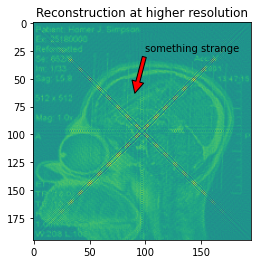

In [60]:
plt.imshow(beta_195.reshape(M,M))
plt.title("Reconstruction at higher resolution")

plt.annotate('something strange', xy=(90, 65), xytext=(100, 25),
            arrowprops=dict(facecolor='red', shrink=0.05))

#### Give a diagnosis on what causes H.S.'s headache and propose a treatment.
Ans: The headache might be caused by a foreign object (rod-like) inside the brain as indicated by the red arrow in the above chart.


### Minimizing the radiation dose (9 points)

Text(0.5, 1.0, 'Reconstruction with 18 orientations')

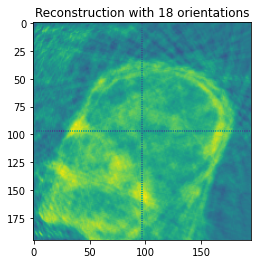

In [48]:
select = np.arange(start=0,stop=len(alphas_195),step=10) #18
alphas_195[select]
X_select = construct_X(M,alphas_195[select],Np)

out = []
for i in select:
    out.extend(np.arange(i*Np,(i+1)*Np))

y_select = y_195[out]
beta_select = linalg.lsqr(A = X_select, b =y_select, atol = 1e-05, btol = 1e-05)[0]

plt.imshow(beta_select.reshape(M,M))
plt.title("Reconstruction with {} orientations".format(len(select)))


Total number of X-ray orientations in full resolution: 179
Full range of orientations available: [-90 -89 -88 -87 -86 -85 -84 -83 -82 -81 -80 -79 -78 -77 -76 -75 -74 -73
 -72 -71 -70 -69 -68 -67 -66 -65 -64 -63 -62 -61 -60 -59 -58 -57 -56 -55
 -54 -53 -52 -51 -50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37
 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19
 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1
   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88]


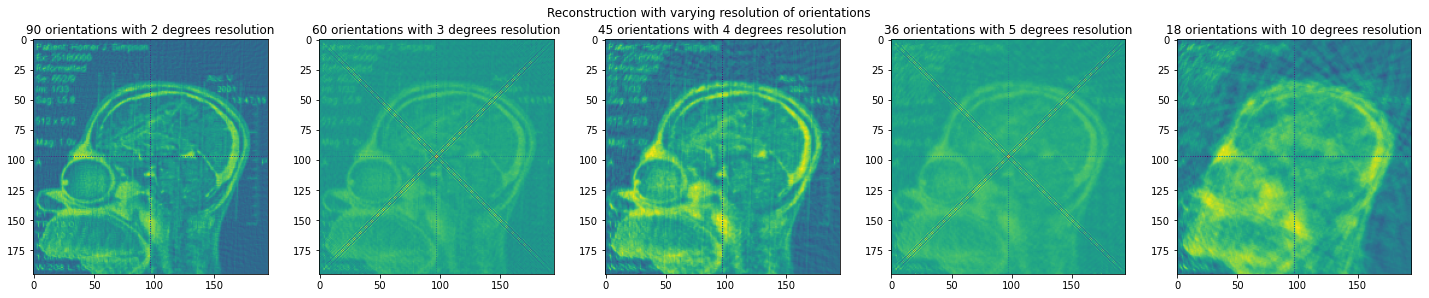

In [61]:
print(f"Total number of X-ray orientations in full resolution: {len(alphas_195)}")
print(f"Full range of orientations available: {alphas_195}")

options = [2,3,4,5,10]
fig, ax = plt.subplots(1,len(options), figsize=(20,4),tight_layout=True)
fig.suptitle('Reconstruction with varying resolution of orientations')
for i in range(len(options)):
    select = np.arange(start=0,stop=len(alphas_195),step=options[i])
    alphas_195[select]
    X_select = construct_X(M,alphas_195[select],Np)

    out = []
    for k in select:
        out.extend(np.arange(k*Np,(k+1)*Np))

    y_select = y_195[out]
    beta_select = linalg.lsqr(A = X_select, b =y_select, atol = 1e-05, btol = 1e-05)[0]

    ax[i].imshow(beta_select.reshape(M,M))
    ax[i].set_title(f"{len(select)} orientations with {options[i]} degrees resolution")


The minimal number of projections required in order to resolve the cause of his headache is at least 45 with 4 degrees of resolution in between.